# **STOCK PRICE PREDICTION LSTM IN PYTHON**

This notebook demonstrates how to predict stock prices using Long Short-Term Memory (LSTM) neural networks. We will use historical stock prices of Apple Inc. (AAPL) over a 10-year period.

Importing Required Libraries

In [ ]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

!pip install yfinance


# Importing Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

Creating a Function to Fetch Stock Data from Yahoo Finance

In [ ]:
def stock_data(stock, start_date, end_date):
    tickerSymbol = stock
    tickerData = yf.Ticker(tickerSymbol)
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)
    return tickerDf

df = stock_data("AAPL", "2014-06-08", "2027-06-08")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-06-09 00:00:00-04:00,20.403681,20.663404,20.194582,20.623785,301660000,0.0,7.0
2014-06-10 00:00:00-04:00,20.850495,20.920929,20.595173,20.744844,251108000,0.0,0.0
2014-06-11 00:00:00-04:00,20.718436,20.857102,20.573167,20.659008,182724000,0.0,0.0
2014-06-12 00:00:00-04:00,20.698625,20.716234,20.227602,20.313442,218996000,0.0,0.0
2014-06-13 00:00:00-04:00,20.293629,20.346455,20.003091,20.091133,218100000,0.0,0.0


Plotting Fetched Data :

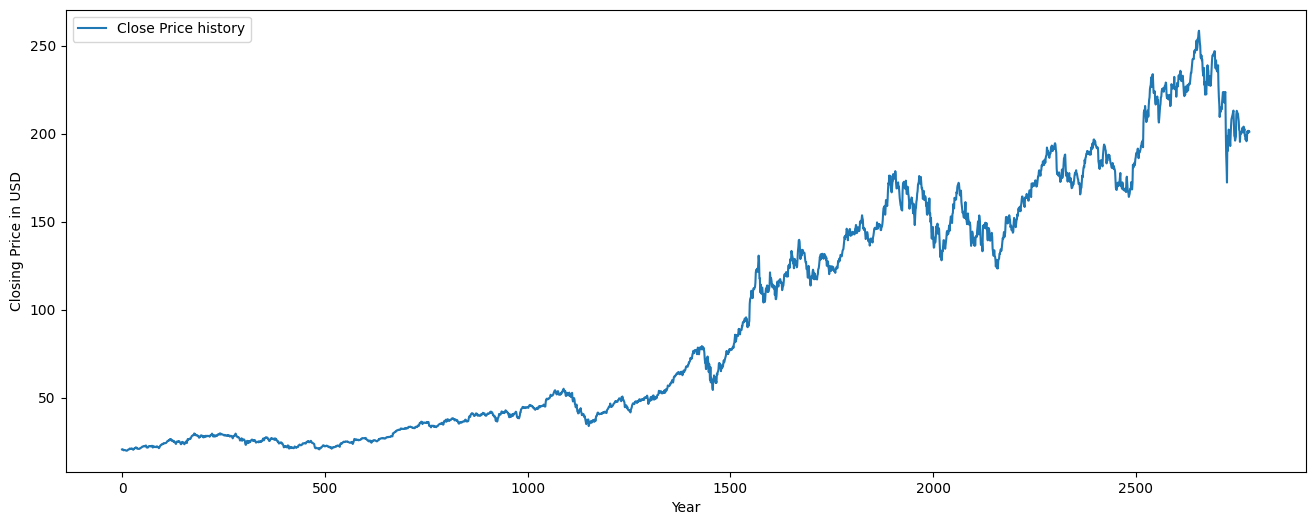

In [ ]:
fig = plt.figure(figsize=(16,6))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.plot(df['Close'], label='Close Price history')
plt.legend()
plt.show()

Checking Data types And  Descriptive Statistics :

In [ ]:
df.dtypes
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2781.000000,2781.000000,2781.000000,2781.000000,2.781000e+03,2781.000000,2781.000000
mean,95.592945,96.637512,94.621775,95.679920,1.192976e+08,0.003025,0.003955
std,69.327831,70.091007,68.629564,69.406459,7.227938e+07,0.024486,0.152858
min,19.855622,19.963472,19.732364,19.871023,2.323470e+07,0.000000,0.000000
25%,32.329945,32.510878,32.202368,32.425056,6.966880e+07,0.000000,0.000000
50%,63.490937,64.044653,63.029133,63.503052,1.013529e+08,0.000000,0.000000
75%,156.505512,158.263978,154.019109,156.276947,1.478228e+08,0.000000,0.000000
max,257.568678,259.474086,257.010028,258.396667,7.593852e+08,0.260000,7.000000


Resetting Index and Dropping Unnecessary Columns :

We reset the index to make the date a column and drop columns that are not required for our analysis.

In [ ]:
df.reset_index(level="Date", inplace=True)
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

Creating Dataset with Closing Price :

We create a dataset with only the closing price column and set the date as the index.

In [ ]:
data = df.sort_index(ascending=True, axis=0)
df1 = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    df1["Date"][i] = data['Date'][i]
    df1["Close"][i] = data["Close"][i]

df1.index = df1.Date
df1.drop("Date", axis=1, inplace=True)
df1.head()

,Close
Date,
2014-06-09 00:00:00-04:00,20.623785
2014-06-10 00:00:00-04:00,20.744844
2014-06-11 00:00:00-04:00,20.659008
2014-06-12 00:00:00-04:00,20.313442
2014-06-13 00:00:00-04:00,20.091133


Splitting Data into Train and Test Sets :

We split the data into training and testing sets

In [ ]:
data = df1.values
train = data[0:1750, :]
test = data[1750:, :]

print(train.shape)
print(test.shape)

(1750, 1)
(1031, 1)


Normalizing the Data :

We normalize the data to the range of 0-1 using MinMaxScaler.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

Preparing Training Data :

We prepare the training data by creating sequences of 60 days to predict the next closing price.

In [ ]:
x_train, y_train = [], []
window = 60

for i in range(window, len(train)):
    x_train.append(scaled_data[i-window:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Preparing Test Data :

We prepare the test data in a similar manner to the training data.

In [ ]:
inputs = df1[len(df1) - len(test) - window:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(window, inputs.shape[0]):
    x_test.append(inputs[i-window:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Building the LSTM Model :

We build and compile the LSTM model.

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', run_eagerly=True)
model.summary()


# We train the model on the training data
model.fit(x_train, y_train, epochs=2, batch_size=64, verbose=2)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
27/27 - 17s - 629ms/step - loss: 0.0069
Epoch 2/2
27/27 - 17s - 618ms/step - loss: 3.3005e-04


Making Predictions :

We make predictions on the test data and transform the results back to the original form.

In [ ]:
closing_price = model.predict(x_test)
train_predict = model.predict(x_train)

closing_price = scaler.inverse_transform(closing_price)
train_predict = scaler.inverse_transform(train_predict)

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 308ms/step


Calculating Performance Metric :

We calculate the Mean Squared Error (MSE) on the test data

In [ ]:
mse = math.sqrt(mean_squared_error(test, closing_price))
print(f"Root Mean Squared Error: {mse}")

Root Mean Squared Error: 7.630478938558648


Plotting the Predictions :

We plot the actual and predicted closing prices.

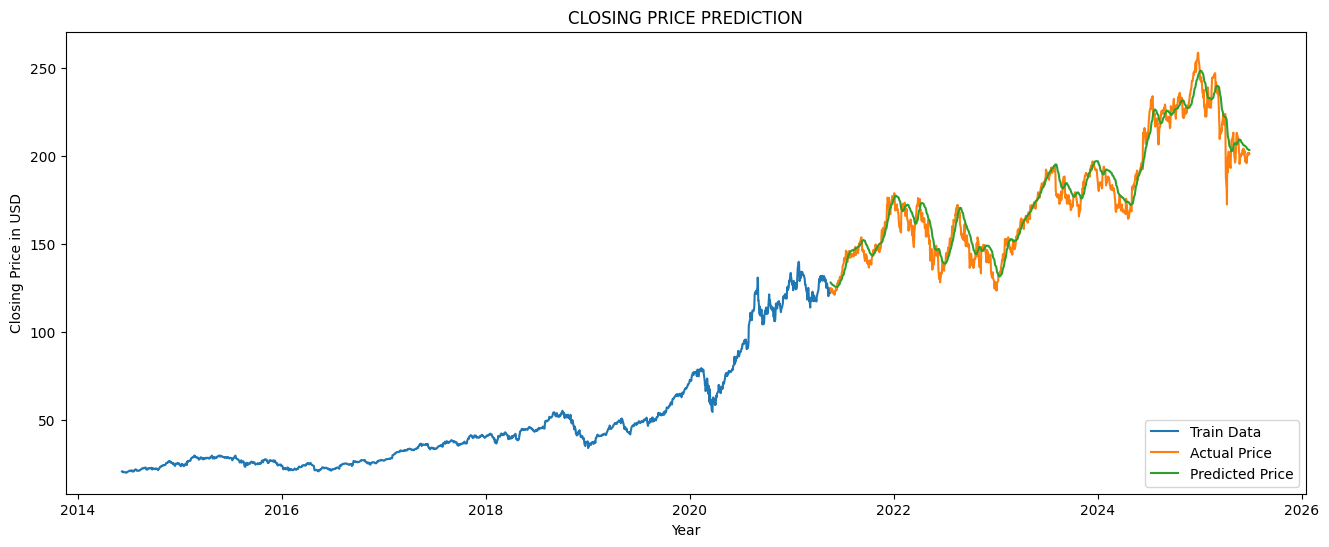

In [ ]:
train = df1[:1750]
test = df1[1750:]
test['Predictions'] = closing_price

plt.figure(figsize=(16,6))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.title("CLOSING PRICE PREDICTION")
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(["Train Data", "Actual Price", "Predicted Price"], loc="lower right")
plt.show()